# Plan2Plan
Author: Jason Jabbour

# Google Colab Set up

Run this if working in a Google Colab

In [ ]:
!git clone https://github.com/jasonjabbour/plan2plan.git

Cloning into 'plan2plan'...
remote: Enumerating objects: 2674, done.
remote: Counting objects: 100% (2674/2674), done.
remote: Compressing objects: 100% (1668/1668), done.
remote: Total 2674 (delta 1002), reused 2668 (delta 999), pack-reused 0
Receiving objects: 100% (2674/2674), 23.30 MiB | 7.98 MiB/s, done.
Resolving deltas: 100% (1002/1002), done.
Updating files: 100% (2022/2022), done.


In [ ]:
%cd plan2plan/Modeling/

/content/plan2plan/Modeling


In [ ]:
!ls

Plan2Plan.ipynb  test_device.py


# Load Dependencies

In [ ]:
import torch
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Plan2Plan Model

## Load Data

In [ ]:
class PathPlanningDataset(Dataset):
    def __init__(self, csv_file, map_dir, transform=None):
        self.path_data = pd.read_csv(csv_file)
        self.map_dir = map_dir
        self.transform = transform
        self.pair_ids = self.path_data['pair_id'].unique()
        self.max_path_length = self.find_max_path_length()

    def find_max_path_length(self):
        # Find the maximum length among all RRT and A* paths
        max_length = 0
        for pair_id in self.pair_ids:
            rrt_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'RRT')]
            astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')]
            max_length = max(max_length, len(rrt_path), len(astar_path))
        return max_length

    def pad_with_eos(self, path_tensor, max_length):
        padded_path = torch.full((max_length, 2), -1.0)  # Using -1.0 as the EOS token
        length = path_tensor.size(0)
        padded_path[:length] = path_tensor
        return padded_path

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]
        # Load map data
        map_path = os.path.join(self.map_dir, f'map_{pair_id}.json')
        with open(map_path, 'r') as f:
            map_data = json.load(f)

        # Load path data
        rrt_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'RRT')][['x', 'y']].values
        astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')][['x', 'y']].values

        # Convert paths to PyTorch tensors
        rrt_tensor = torch.tensor(rrt_path, dtype=torch.float32)
        astar_tensor = torch.tensor(astar_path, dtype=torch.float32)
        # Convert map to tensor
        map_tensor = torch.tensor(map_data, dtype=torch.float32)

        # Pad paths with the EOS token to ensure consistent length
        rrt_tensor = self.pad_with_eos(rrt_tensor, self.max_path_length)
        astar_tensor = self.pad_with_eos(astar_tensor, self.max_path_length)

        return {'map': map_tensor, 'rrt_path': rrt_tensor, 'astar_path': astar_tensor}


def collate_fn(batch):
    maps = [item['map'] for item in batch]
    rrt_paths = [item['rrt_path'] for item in batch]
    astar_paths = [item['astar_path'] for item in batch]

    # Stack the sequences as they are already padded
    rrt_padded = torch.stack(rrt_paths)
    astar_padded = torch.stack(astar_paths)

    # Create attention masks
    rrt_masks = (rrt_padded[:, :, 0] != -1)  # Masking where the EOS token is not present
    astar_masks = (astar_padded[:, :, 0] != -1)  # Same for A* paths

    maps_stacked = torch.stack(maps)

    return {'map': maps_stacked, 'rrt_path': rrt_padded, 'astar_path': astar_padded, 'rrt_mask': rrt_masks, 'astar_mask': astar_masks}


# Usage
batch_size = 32
dataset = PathPlanningDataset(csv_file='../PathPlanning/path_data/path_data.csv', map_dir='../PathPlanning/map_data')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

Test the data loader

In [ ]:
# To test the dataloader, you can iterate over it
for i, data in enumerate(dataloader):
    print(f"Batch {i}")
    print(data['map'].shape, data['rrt_path'].shape, data['astar_path'].shape, data['rrt_mask'].shape, data['astar_mask'].shape)
    break


Batch 0
torch.Size([32, 100, 100]) torch.Size([32, 175, 2]) torch.Size([32, 175, 2]) torch.Size([32, 175]) torch.Size([32, 175])


Merge Path and Map Function

In [ ]:
# def modify_maps_with_paths(batch_maps, batch_paths, batch_masks):
#     """
#     Modify a batch of maps with the corresponding batch of paths.

#     Args:
#     - batch_maps (Tensor): Batch of maps, shape (batch_size, 1, height, width).
#     - batch_paths (Tensor): Batch of paths, shape (batch_size, seq_length, 2).
#     - batch_masks (Tensor): Batch of masks, shape (batch_size, seq_length).

#     Returns:
#     - Tensor: Batch of modified maps.
#     """
#     modified_maps = []
#     for i in range(batch_maps.shape[0]):
#         # Move tensors to CPU and convert to numpy for processing
#         map_np = batch_maps[i].squeeze().cpu().numpy()
#         path_np = batch_paths[i].cpu().numpy()
#         mask_np = batch_masks[i].cpu().numpy() if batch_masks is not None else None

#         # Modify the map with the path
#         modified_map = modify_map_with_path(map_np, path_np, mask_np)
#         modified_maps.append(modified_map)

#     return torch.tensor(modified_maps, device=batch_maps.device)

def modify_maps_with_paths_tensor(batch_maps, batch_paths, batch_masks=None):
    modified_maps = batch_maps.clone()  # Create a copy to modify
    for i in range(batch_maps.size(0)):
        modified_maps[i] = modify_map_with_path_tensor(modified_maps[i], batch_paths[i], batch_masks[i] if batch_masks is not None else None)
    return modified_maps

def modify_map_with_path_tensor(map_tensor, path_tensor, mask_tensor=None):
    """
    Modify map_tensor with the given path_tensor, excluding coordinates where mask_tensor is False.

    Args:
    - map_tensor (Tensor): The map as a 2D tensor.
    - path_tensor (Tensor): The path as a tensor of (x, y) coordinates.
    - mask_tensor (Tensor, optional): A boolean tensor of the same shape as path_tensor.
                                      If provided, only the coordinates where mask_tensor is True
                                      will be marked.

    Returns:
    - Tensor: The modified map.
    """
    for i, (x, y) in enumerate(path_tensor):
        # Check mask, if provided
        if mask_tensor is not None and not mask_tensor[i]:
            continue

        # Mark the path on the map, avoiding overwriting start/end points
        if 0 <= x < map_tensor.shape[1] and 0 <= y < map_tensor.shape[0]:
            if map_tensor[int(y), int(x)] not in {2, 3}:  # Assuming 2 and 3 are special values not to be overwritten
                map_tensor[int(y), int(x)] = 4  # Mark the path

    return map_tensor

def modify_map_with_path(map_matrix, path, mask=None):
    """
    Modify map_matrix with the given path, excluding coordinates where mask is False.

    Args:
    - map_matrix (np.ndarray): The map as a 2D numpy array.
    - path (list of tuples): The path as a list of (x, y) coordinates.
    - mask (np.ndarray, optional): A boolean array of the same shape as map_matrix.
                                   If provided, only the coordinates where mask is True
                                   will be marked.

    Returns:
    - np.ndarray: The modified map.


    Maps are (100,100) matrices that have 4 values.

    0: White-space no obstacle
    1: Obstacle
    2: Start
    3: End
    4: Path

    """
    modified_map = np.copy(map_matrix)
    index = 0
    for (x, y) in path:
        if 0 <= x < modified_map.shape[1] and 0 <= y < modified_map.shape[0]:
            # If a mask is provided and the mask value is False, skip marking this coordinate
            if mask is not None and not mask[index]:
                continue

            current_value = modified_map[int(y), int(x)]
            # Avoid overwriting start (2) and end (3) points
            if current_value not in {2, 3}:
                modified_map[int(y), int(x)] = 4  # Mark the path

        index+=1

    return modified_map



Visualize Merged Path and Map

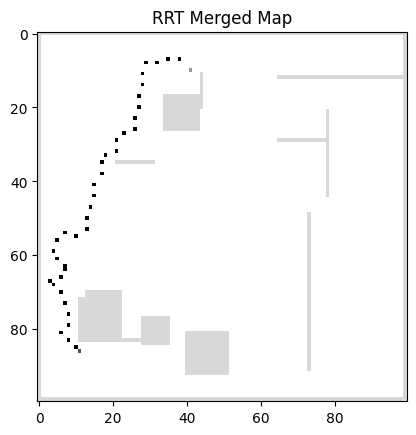

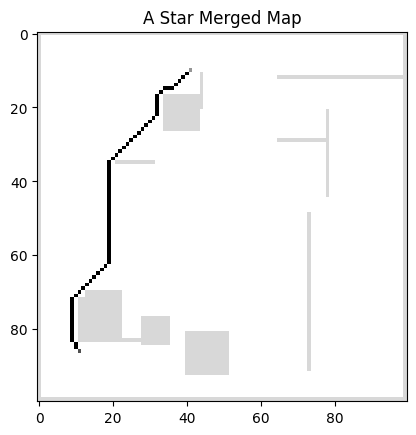

(100, 100)

In [ ]:
# Get a batch of data
data = next(iter(dataloader))
maps = data['map']

# Modify the maps with the RRT paths
modified_maps = []
for i in range(maps.size(0)):
    rrt_modified_map = modify_map_with_path(maps[i].numpy(), data['rrt_path'][i].numpy(), data['rrt_mask'][i].numpy())
    astar_modified_map = modify_map_with_path(maps[i].numpy(), data['astar_path'][i].numpy(), data['astar_mask'][i].numpy())
    break

# The number 4 represents the paths.
# If you only want to display the paths then zero everything else out.
# modified_map_rrt[modified_map_rrt != 4] = 0
# modified_map_astar[modified_map_astar != 4] = 0

# Visualize the first generated map
plt.imshow(rrt_modified_map.squeeze(), cmap='Greys')
plt.title("RRT Merged Map")
plt.show()

# Visualize the first generated map
plt.imshow(astar_modified_map.squeeze(), cmap='Greys')
plt.title("A Star Merged Map")
plt.show()

rrt_modified_map.shape

## Generator

In [ ]:
class ConvolutionalBase(nn.Module):
    """
    A convolutional base to process the input map and extract features.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # Reduce dimensions for feature extraction
        return x

class PathTransformer(nn.Module):
    """
    A transformer to process the RRT path and generate the A* path.
    """
    def __init__(self, embedding_dim, nhead, num_encoder_layers, num_decoder_layers, num_classes):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, path_embeddings, map_features, path_mask):
        # Assuming map_features and path_embeddings are prepared correctly
        transformer_output = self.transformer_encoder(path_embeddings, src_key_padding_mask=path_mask)
        path_predictions = self.classifier(transformer_output)
        return path_predictions

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, embedding_dim, nhead, num_encoder_layers, num_decoder_layers):
        super().__init__()
        self.conv_base = ConvolutionalBase()
        self.path_transformer = PathTransformer(embedding_dim, nhead, num_encoder_layers, num_decoder_layers, output_channels)

        # Project path coordinates to higher-dimensional space
        self.coord_to_embedding = nn.Linear(2, embedding_dim)  # Projecting 2D coordinates to embedding_dim
        self.embedding_dim = embedding_dim

    def forward(self, obstacle_map, rrt_path, rrt_mask):

        # rrt_mask = rrt_mask.transpose(0, 1)

        map_features = self.conv_base(obstacle_map)

        # Project path coordinates to embeddings
        rrt_embeddings = self.coord_to_embedding(rrt_path) * math.sqrt(self.embedding_dim)

        # Pass embeddings and map features to the transformer
        transformer_output = self.path_transformer(rrt_embeddings, map_features, rrt_mask)

        # Separate the path coordinates and EOS probability
        path_coordinates = transformer_output[..., :-1]  # All dimensions except last
        eos_probabilities = transformer_output[..., -1]  # Last dimension

        # Scale the path coordinates to be in range [0, 1]
        path_coordinates_scaled = torch.sigmoid(path_coordinates)

        # Optionally scale to map dimensions
        map_height, map_width = 100, 100  # Replace with actual map dimensions
        path_coordinates_scaled = path_coordinates_scaled * torch.tensor([map_width, map_height]).to(path_coordinates_scaled.device)

        # Apply sigmoid to EOS probabilities
        eos_probabilities = torch.sigmoid(eos_probabilities)

        return path_coordinates_scaled, eos_probabilities


# Example usage
input_channels = 1
output_channels = 3
embedding_dim = 512
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3

generator = Generator(input_channels, output_channels, embedding_dim, nhead, num_encoder_layers, num_decoder_layers)

Identify the Path using the EOS Token

In [ ]:
def find_truncated_path(generated_path, eos_probabilities, eos_threshold=0.9):
    """
    Truncates the generated path based on the EOS probabilities.

    Args:
    - generated_path (np.ndarray): Generated path array.
    - eos_probabilities (np.ndarray): Array of EOS probabilities.
    - eos_threshold (float): Threshold for EOS detection.

    Returns:
    - np.ndarray: Truncated path.
    """
    # Check if any EOS probability is above the threshold
    eos_indices = np.where(eos_probabilities > eos_threshold)[0]

    # If EOS is detected, truncate the path at the first occurrence of EOS
    if len(eos_indices) > 0:
        truncated_path = generated_path[:eos_indices[0], :]
    else:
        # If no EOS detected, use the entire path
        truncated_path = generated_path

    return truncated_path


def find_truncated_paths_batch(generated_paths, eos_probabilities, eos_threshold=0.9):
    """
    Truncates each path in a batch of generated paths based on their corresponding EOS probabilities.

    Args:
    - generated_paths (Tensor): Batch of generated paths, shape (batch_size, seq_length, 2).
    - eos_probabilities (Tensor): Batch of EOS probabilities, shape (batch_size, seq_length).
    - eos_threshold (float): Threshold for EOS detection.

    Returns:
    - List[Tensor]: List of truncated paths, each with potentially different lengths.
    """
    truncated_paths = []

    for path, eos_probs in zip(generated_paths, eos_probabilities):
        eos_indices = torch.where(eos_probs > eos_threshold)[0]

        if len(eos_indices) > 0:
            truncated_path = path[:eos_indices[0], :]
        else:
            truncated_path = path

        truncated_paths.append(truncated_path)

    return truncated_paths


# def find_truncated_paths_batch(generated_paths, eos_probabilities, eos_threshold=0.9):
#     """
#     Truncates each path in a batch of generated paths based on their corresponding EOS probabilities.

#     Args:
#     - generated_paths (Tensor): Batch of generated paths, shape (batch_size, seq_length, 2).
#     - eos_probabilities (Tensor): Batch of EOS probabilities, shape (batch_size, seq_length).
#     - eos_threshold (float): Threshold for EOS detection.

#     Returns:
#     - Tensor: Batch of truncated paths.
#     """
#     truncated_paths = []

#     for path, eos_probs in zip(generated_paths, eos_probabilities):
#         eos_indices = torch.where(eos_probs > eos_threshold)[0]

#         if len(eos_indices) > 0:
#             truncated_path = path[:eos_indices[0], :]
#         else:
#             truncated_path = path

#         truncated_paths.append(truncated_path)

#     # Padding the truncated paths to have the same sequence length
#     seq_length = max([len(p) for p in truncated_paths])
#     padded_truncated_paths = torch.stack([torch.cat([p, torch.full((seq_length - p.size(0), 2), -1.0, device=p.device)], dim=0) for p in truncated_paths])

#     return padded_truncated_paths

Test the output of the generator on a random map

Generated Path: [[53.63779  49.124283]
 [51.53227  59.06455 ]
 [53.249886 49.85298 ]
 [54.66424  53.727005]
 [59.982376 54.31703 ]
 [56.49393  55.713497]]
EOS Probabilities: [0.2934744  0.24639672 0.27760673 0.2836574  0.28751048 0.33647504]
Truncated Path: [[53.63779  49.124283]
 [51.53227  59.06455 ]
 [53.249886 49.85298 ]
 [54.66424  53.727005]
 [59.982376 54.31703 ]
 [56.49393  55.713497]]


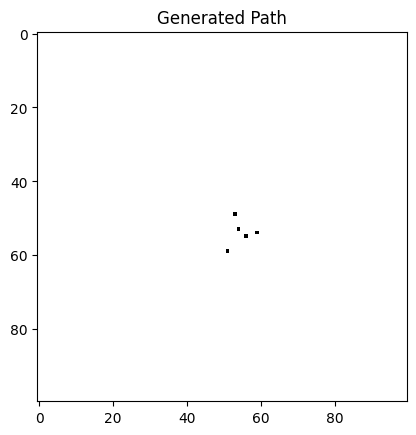

In [ ]:
# Example input data
obstacle_map = torch.zeros(1, 1, 100, 100)
rrt_path = torch.tensor([[[67., 54.], [69.91, 54.72], [72.18, 56.68], [72.32, 59.68], [70.84, 62.29], [68.22, 63.74]]], dtype=torch.float32)
rrt_mask = torch.ones(1, rrt_path.size(1))  # Create mask based on path length

# Generate path and EOS probabilities
generated_path, eos_probabilities = generator(obstacle_map, rrt_path, rrt_mask)

# Convert to NumPy
generated_path_np = generated_path.squeeze().detach().cpu().numpy()
eos_probabilities_np = eos_probabilities.squeeze().detach().cpu().numpy()

# Example usage
eos_threshold = 0.9  # Look for high probability you are at the end of the sequence
truncated_path_np = find_truncated_path(generated_path_np, eos_probabilities_np, eos_threshold)

print(f"Generated Path: {generated_path_np}")
print(f"EOS Probabilities: {eos_probabilities_np}")
print(f"Truncated Path: {truncated_path_np}")

# Visualization
generated_map = modify_map_with_path(obstacle_map.squeeze().numpy(), truncated_path_np)
plt.imshow(generated_map, cmap='Greys')
plt.title("Generated Path")
plt.show()




Plot function to help visualize the maps and generated paths.

In [ ]:
def plot_maps(rrt_map, astar_map, generated_path, truncated_path, map):

    # Visualize the maps and paths
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 4, 1)
    plt.imshow(rrt_map, cmap='Greys')
    plt.title("RRT Path on Map")

    plt.subplot(1, 4, 2)
    plt.imshow(astar_map, cmap='Greys')
    plt.title("A* Path on Map")

    plt.subplot(1, 4, 3)
    full_generated_map = modify_map_with_path(map, generated_path)
    plt.imshow(full_generated_map, cmap='Greys')
    plt.title("Full Generated Path")

    plt.subplot(1, 4, 4)
    truncated_generated_map = modify_map_with_path(map, truncated_path)
    plt.imshow(truncated_generated_map, cmap='Greys')
    plt.title("Truncated Generated Path")

    plt.savefig('../captures/transformer_training_start0.png', dpi=500)
    plt.show()


Test the generator on real RRT Paths and Visualize

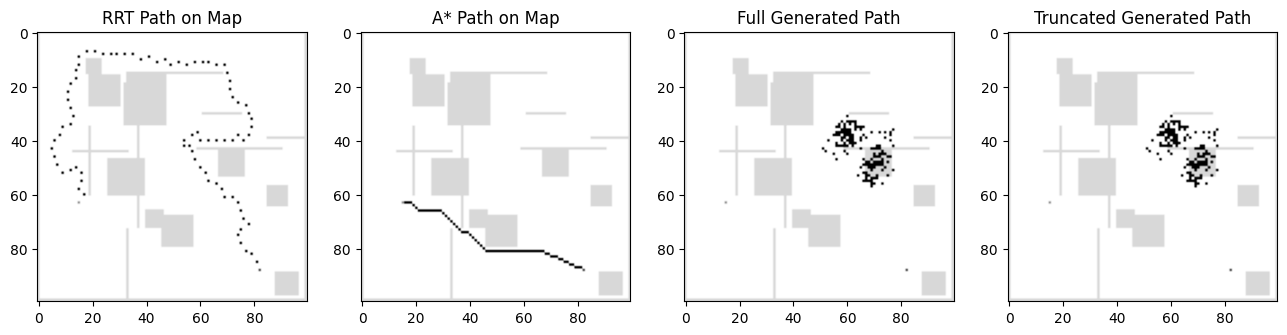

In [ ]:
# Get a batch of data
data = next(iter(dataloader))
map = data['map'][0].numpy()
rrt_path = data['rrt_path'][0].numpy()
astar_path = data['astar_path'][0].numpy()
rrt_mask = data['rrt_mask'][0].numpy()
astar_mask = data['astar_mask'][0].numpy()

rrt_modified_map = modify_map_with_path(map, rrt_path, rrt_mask)
astar_modified_map = modify_map_with_path(map, astar_path, astar_mask)

# Convert your NumPy arrays to PyTorch tensors
map_tensor = torch.from_numpy(map)
rrt_path_tensor = torch.from_numpy(rrt_path)
rrt_mask_tensor = torch.from_numpy(rrt_mask)

# Generate the output map
with torch.no_grad():
    generated_path, eos_probabilities = generator(map_tensor.unsqueeze(0), rrt_path_tensor.unsqueeze(0), rrt_mask_tensor.unsqueeze(0))

# Convert the generated_path and eos_probabilities back to NumPy arrays if needed
generated_path = generated_path.squeeze().cpu().numpy()
eos_probabilities = eos_probabilities.squeeze().cpu().numpy()

# Truncate the path
eos_threshold = 0.9
truncated_path = find_truncated_path(generated_path, eos_probabilities, eos_threshold)

# Plot the maps
plot_maps(rrt_modified_map, astar_modified_map, generated_path, truncated_path, map)

GAN Loss Function

In [ ]:
def create_obstacle_mask(map_tensor, obstacle_value=1):
    # Assuming obstacle is represented by '1'
    return (map_tensor == obstacle_value).float()

def generator_loss(disc_output, gen_paths, target_paths, eos_probabilities, astar_mask, generated_modified_maps, map_tensor):
    # Adversarial loss (Binary Cross Entropy with Logits)
    adversarial_loss = F.binary_cross_entropy_with_logits(disc_output, torch.ones_like(disc_output))

    # Path similarity loss (Mean Squared Error)
    valid_points = astar_mask.unsqueeze(2).expand_as(gen_paths)  # Expand mask to match gen_paths shape
    path_similarity_loss = F.mse_loss(gen_paths * valid_points, target_paths * valid_points)

    # End points loss (Mean Squared Error on start and end points)
    start_point_loss = F.mse_loss(gen_paths[:, 0, :], target_paths[:, 0, :])
    end_point_loss = F.mse_loss(gen_paths.gather(1, (astar_mask.sum(1, keepdim=True) - 1).unsqueeze(-1).expand(-1, -1, 2)),
                                target_paths.gather(1, (astar_mask.sum(1, keepdim=True) - 1).unsqueeze(-1).expand(-1, -1, 2)))

    # Obstacle loss
    obstacle_mask = create_obstacle_mask(map_tensor)
    path_mask = (generated_modified_maps == 4).float()  # Assuming path is represented by '4'
    overlap = obstacle_mask * path_mask  # Element-wise multiplication
    obstacle_loss = overlap.mean()  # Mean overlap across the batch

    # Check if both x and y coordinates are -1 (EOS token)
    target_eos = (target_paths == -1).all(dim=2).float()  # Shape will be [batch_size, sequence_length]
    # EOS prediction loss (Binary Cross Entropy)
    eos_prediction_loss = F.binary_cross_entropy_with_logits(eos_probabilities, target_eos)

    # Weights for each component of the loss
    w_adv = 0.5
    w_path_sim = 1.0
    w_end_points = 0.1
    w_eos_pred = 0.1
    w_obstacle = 1.0

    # Total generator loss with weighting
    total_loss = (w_adv * adversarial_loss +
                  w_path_sim * path_similarity_loss +
                  w_end_points * (start_point_loss + end_point_loss) +
                  w_eos_pred * eos_prediction_loss +
                  w_obstacle * obstacle_loss)
    return total_loss

## Discriminator

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, input_dim, hidden_dim, window_size):
#         super().__init__()
#         self.window_size = window_size
#         self.conv = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=window_size, stride=1, padding=window_size//2)
#         self.classifier = nn.Linear(hidden_dim, 1)

#     def forward(self, real_path, fake_path):
#         """
#         Forward pass for the discriminator using a sliding window approach.

#         Args:
#             real_path: Tensor of shape (batch_size, sequence_length, input_dim)
#                        Contains real path sequences.
#             fake_path: Tensor of shape (batch_size, sequence_length, input_dim)
#                        Contains generated path sequences.

#         Returns:
#             logits: Discriminator logits for the concatenated sequences.
#         """
#         # Concatenate the real and generated paths along the sequence dimension
#         combined_path = torch.cat([real_path, fake_path], dim=1)  # shape: (batch_size, sequence_length*2, input_dim)

#         # Apply sliding window approach
#         combined_path = combined_path.transpose(1, 2)  # Conv1d expects (batch_size, channels, length)
#         features = self.conv(combined_path)  # Apply convolution along the sequence length

#         # Collapse the features from sliding windows into one dimension per sequence
#         pooled_features = F.adaptive_avg_pool1d(features, 1).squeeze(-1)

#         # Pass pooled features to the classifier
#         logits = self.classifier(pooled_features)
#         return logits

class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        # Assuming square images and grayscale (1 channel) paths
        self.image_size = image_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1)  # Input will have 2 channels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        # Calculate the size of the feature map after the convolutional layers
        conv_output_size = image_size // 4  # Adjust based on your convolutional layers' architecture

        # Fully connected layer
        self.fc = nn.Linear(128 * conv_output_size * conv_output_size, 1)

        # LeakyReLU activation and Dropout
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, real_image, fake_image):
        # Stack the real and fake images along the channel dimension
        combined_image = torch.cat([real_image, fake_image], dim=1)  # shape: (batch_size, 2, height, width)

        # Passing through the convolutional layers
        x = self.leaky_relu(self.conv1(combined_image))
        x = self.dropout(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.dropout(x)

        # Flattening and passing through the fully connected layer
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)

        return logits

Discriminator Loss

In [ ]:
# Binary Cross-Entropy loss with logits
# This loss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    Calculate discriminator loss.

    Args:
    - disc_real_output (tensor): Discriminator output for real data.
    - disc_generated_output (tensor): Discriminator output for generated (fake) data.

    Returns:
    - total_disc_loss (tensor): Total loss for the discriminator.
    """
    # Real loss - how well the discriminator classifies real images
    real_loss = criterion(disc_real_output, torch.ones_like(disc_real_output))

    # Generated loss - how well the discriminator classifies generated images
    generated_loss = criterion(disc_generated_output, torch.zeros_like(disc_generated_output))

    # Total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Training

Check for CUDA

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


Best Model Saved at Gen_Loss: 454.0140686035156.
Best Model Saved at Gen_Loss: 399.83172607421875.
Best Model Saved at Gen_Loss: 391.301025390625.
Best Model Saved at Gen_Loss: 381.4056701660156.
Best Model Saved at Gen_Loss: 377.7613830566406.
Best Model Saved at Gen_Loss: 304.1688232421875.
Epoch [1/1000], Total Steps: 32, G Total Loss: 375.44036865234375, D Loss: 1.4019930362701416
Checkpoint saved at epoch 0.


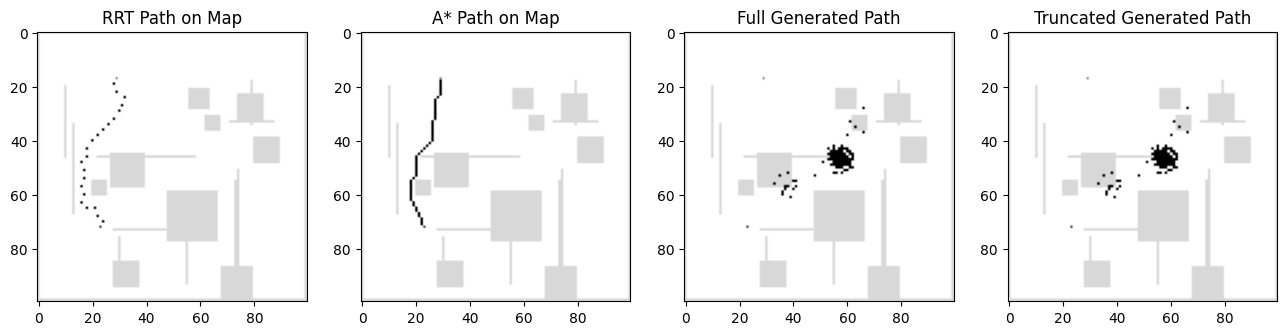

Best Model Saved at Gen_Loss: 297.10955810546875.
Epoch [2/1000], Total Steps: 64, G Total Loss: 350.3379821777344, D Loss: 1.3967546224594116
Best Model Saved at Gen_Loss: 294.1498718261719.
Best Model Saved at Gen_Loss: 219.5775909423828.
Epoch [3/1000], Total Steps: 96, G Total Loss: 219.5775909423828, D Loss: 1.391716480255127
Epoch [4/1000], Total Steps: 128, G Total Loss: 354.61175537109375, D Loss: 1.3904904127120972
Epoch [5/1000], Total Steps: 160, G Total Loss: 383.67144775390625, D Loss: 1.36598539352417
Epoch [6/1000], Total Steps: 192, G Total Loss: 323.50079345703125, D Loss: 1.3855464458465576
Epoch [7/1000], Total Steps: 224, G Total Loss: 388.5122985839844, D Loss: 1.3902013301849365
Epoch [8/1000], Total Steps: 256, G Total Loss: 326.6579284667969, D Loss: 1.386411190032959
Epoch [9/1000], Total Steps: 288, G Total Loss: 321.15301513671875, D Loss: 1.388899326324463
Epoch [10/1000], Total Steps: 320, G Total Loss: 251.67611694335938, D Loss: 1.4100698232650757
Epoch [

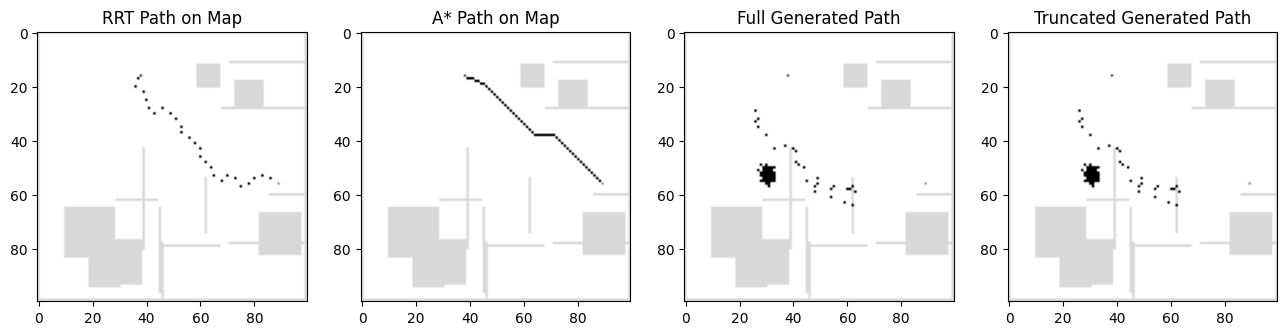

Epoch [12/1000], Total Steps: 384, G Total Loss: 353.6797790527344, D Loss: 1.4094218015670776
Epoch [13/1000], Total Steps: 416, G Total Loss: 290.1495666503906, D Loss: 1.3601412773132324
Epoch [14/1000], Total Steps: 448, G Total Loss: 371.77764892578125, D Loss: 1.3884940147399902
Epoch [15/1000], Total Steps: 480, G Total Loss: 257.4453430175781, D Loss: 1.4220800399780273
Epoch [16/1000], Total Steps: 512, G Total Loss: 287.29876708984375, D Loss: 1.4301624298095703
Epoch [17/1000], Total Steps: 544, G Total Loss: 240.82229614257812, D Loss: 1.3721919059753418
Epoch [18/1000], Total Steps: 576, G Total Loss: 296.8514404296875, D Loss: 1.4013242721557617
Epoch [19/1000], Total Steps: 608, G Total Loss: 262.07177734375, D Loss: 1.4074288606643677
Epoch [20/1000], Total Steps: 640, G Total Loss: 230.88943481445312, D Loss: 1.4032315015792847
Epoch [21/1000], Total Steps: 672, G Total Loss: 302.55181884765625, D Loss: 1.3703629970550537
Checkpoint saved at epoch 20.


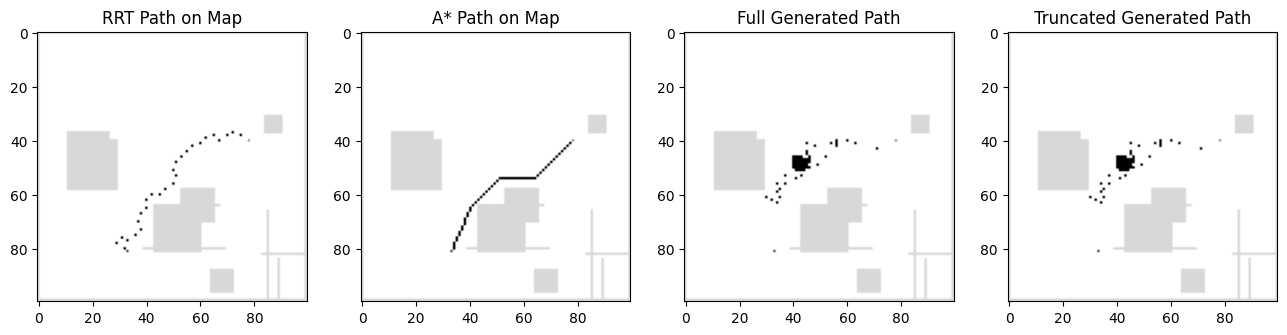

Epoch [22/1000], Total Steps: 704, G Total Loss: 276.91107177734375, D Loss: 1.3977949619293213
Epoch [23/1000], Total Steps: 736, G Total Loss: 450.38909912109375, D Loss: 1.4230471849441528
Epoch [24/1000], Total Steps: 768, G Total Loss: 355.6104736328125, D Loss: 1.3888616561889648
Epoch [25/1000], Total Steps: 800, G Total Loss: 324.8705749511719, D Loss: 1.4000619649887085
Epoch [26/1000], Total Steps: 832, G Total Loss: 328.3345031738281, D Loss: 1.3796497583389282
Epoch [27/1000], Total Steps: 864, G Total Loss: 253.62118530273438, D Loss: 1.3970794677734375
Epoch [28/1000], Total Steps: 896, G Total Loss: 309.6280212402344, D Loss: 1.421946406364441
Epoch [29/1000], Total Steps: 928, G Total Loss: 261.215087890625, D Loss: 1.4017629623413086
Epoch [30/1000], Total Steps: 960, G Total Loss: 291.14678955078125, D Loss: 1.3849637508392334
Epoch [31/1000], Total Steps: 992, G Total Loss: 308.284423828125, D Loss: 1.3976168632507324
Checkpoint saved at epoch 30.


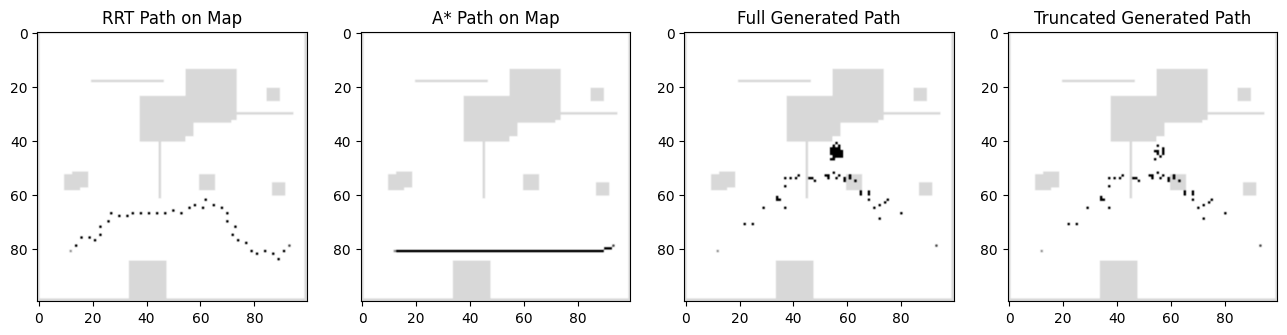

Best Model Saved at Gen_Loss: 216.96067810058594.
Epoch [32/1000], Total Steps: 1024, G Total Loss: 331.0904235839844, D Loss: 1.4149060249328613
Best Model Saved at Gen_Loss: 210.9909210205078.
Epoch [33/1000], Total Steps: 1056, G Total Loss: 285.73065185546875, D Loss: 1.4217758178710938
Epoch [34/1000], Total Steps: 1088, G Total Loss: 442.6404724121094, D Loss: 1.396623134613037
Best Model Saved at Gen_Loss: 174.53213500976562.
Epoch [35/1000], Total Steps: 1120, G Total Loss: 174.53213500976562, D Loss: 1.3963680267333984
Epoch [36/1000], Total Steps: 1152, G Total Loss: 216.34751892089844, D Loss: 1.341662883758545
Epoch [37/1000], Total Steps: 1184, G Total Loss: 308.211181640625, D Loss: 1.3805882930755615
Epoch [38/1000], Total Steps: 1216, G Total Loss: 225.7620086669922, D Loss: 1.4094362258911133
Epoch [39/1000], Total Steps: 1248, G Total Loss: 304.7501220703125, D Loss: 1.3908381462097168
Epoch [40/1000], Total Steps: 1280, G Total Loss: 323.1166076660156, D Loss: 1.4183

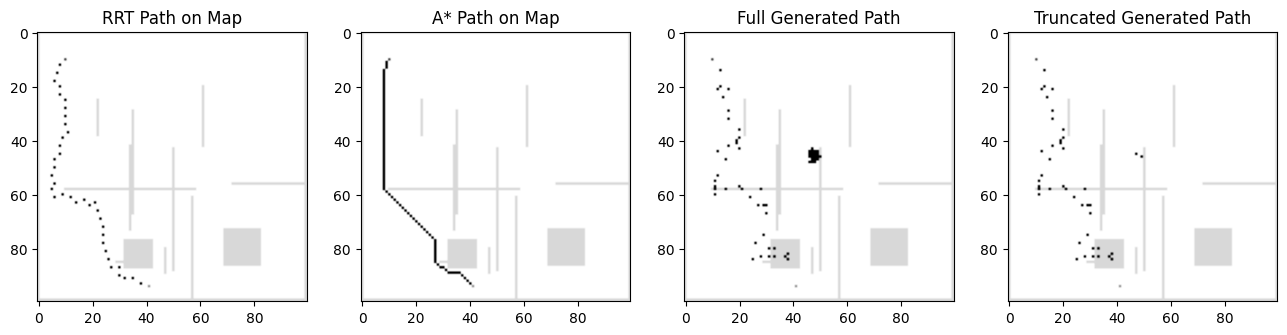

Epoch [42/1000], Total Steps: 1344, G Total Loss: 381.1490478515625, D Loss: 1.404642105102539
Epoch [43/1000], Total Steps: 1376, G Total Loss: 317.0453186035156, D Loss: 1.4159722328186035
Epoch [44/1000], Total Steps: 1408, G Total Loss: 286.2439270019531, D Loss: 1.3685917854309082
Epoch [45/1000], Total Steps: 1440, G Total Loss: 207.52378845214844, D Loss: 1.363175392150879
Epoch [46/1000], Total Steps: 1472, G Total Loss: 372.41717529296875, D Loss: 1.3661878108978271
Epoch [47/1000], Total Steps: 1504, G Total Loss: 330.69189453125, D Loss: 1.4021153450012207
Epoch [48/1000], Total Steps: 1536, G Total Loss: 374.72271728515625, D Loss: 1.3882652521133423
Epoch [49/1000], Total Steps: 1568, G Total Loss: 316.46343994140625, D Loss: 1.3908451795578003
Epoch [50/1000], Total Steps: 1600, G Total Loss: 293.67047119140625, D Loss: 1.3758904933929443
Epoch [51/1000], Total Steps: 1632, G Total Loss: 205.4656524658203, D Loss: 1.3863656520843506
Checkpoint saved at epoch 50.


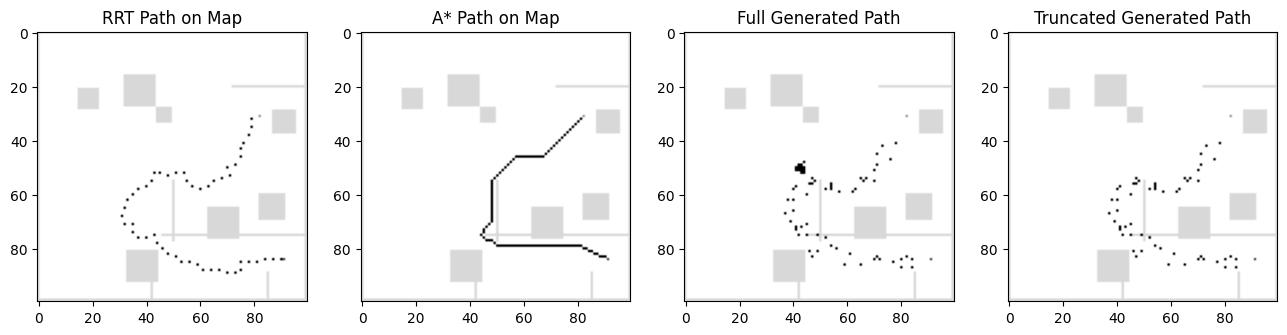

Epoch [52/1000], Total Steps: 1664, G Total Loss: 332.66473388671875, D Loss: 1.3670777082443237
Epoch [53/1000], Total Steps: 1696, G Total Loss: 424.1050109863281, D Loss: 1.3689136505126953
Epoch [54/1000], Total Steps: 1728, G Total Loss: 298.7169189453125, D Loss: 1.3900902271270752
Epoch [55/1000], Total Steps: 1760, G Total Loss: 229.82806396484375, D Loss: 1.3753666877746582
Epoch [56/1000], Total Steps: 1792, G Total Loss: 311.44244384765625, D Loss: 1.3968253135681152
Epoch [57/1000], Total Steps: 1824, G Total Loss: 248.83827209472656, D Loss: 1.3797516822814941
Epoch [58/1000], Total Steps: 1856, G Total Loss: 442.0877380371094, D Loss: 1.4079489707946777
Epoch [59/1000], Total Steps: 1888, G Total Loss: 329.3584289550781, D Loss: 1.3894559144973755
Epoch [60/1000], Total Steps: 1920, G Total Loss: 215.97897338867188, D Loss: 1.399308443069458
Epoch [61/1000], Total Steps: 1952, G Total Loss: 234.8848876953125, D Loss: 1.3859939575195312
Checkpoint saved at epoch 60.


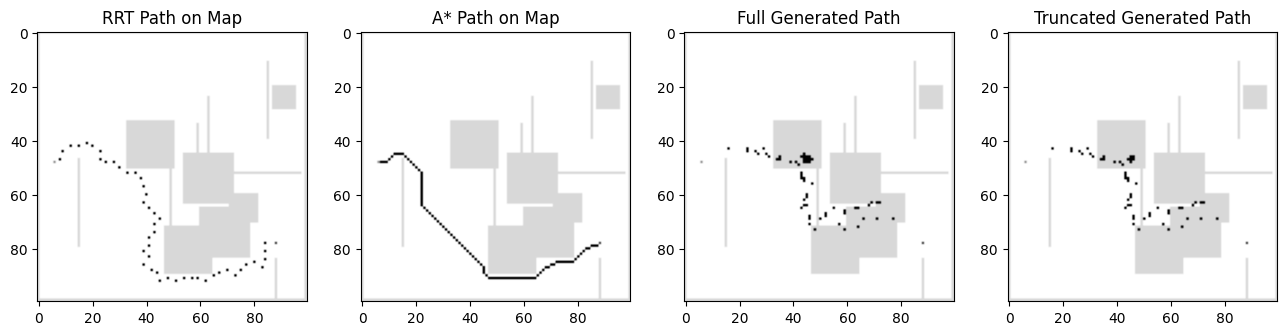

Epoch [62/1000], Total Steps: 1984, G Total Loss: 339.1814880371094, D Loss: 1.3879730701446533
Epoch [63/1000], Total Steps: 2016, G Total Loss: 268.7804260253906, D Loss: 1.3474147319793701
Epoch [64/1000], Total Steps: 2048, G Total Loss: 288.8763122558594, D Loss: 1.3739713430404663
Epoch [65/1000], Total Steps: 2080, G Total Loss: 258.8716125488281, D Loss: 1.3786835670471191
Epoch [66/1000], Total Steps: 2112, G Total Loss: 280.9515380859375, D Loss: 1.3824412822723389
Epoch [67/1000], Total Steps: 2144, G Total Loss: 295.4691162109375, D Loss: 1.40108323097229
Epoch [68/1000], Total Steps: 2176, G Total Loss: 248.37945556640625, D Loss: 1.3904643058776855
Epoch [69/1000], Total Steps: 2208, G Total Loss: 257.8094482421875, D Loss: 1.388533353805542
Epoch [70/1000], Total Steps: 2240, G Total Loss: 266.83526611328125, D Loss: 1.3924846649169922
Epoch [71/1000], Total Steps: 2272, G Total Loss: 313.5436706542969, D Loss: 1.3869285583496094
Checkpoint saved at epoch 70.


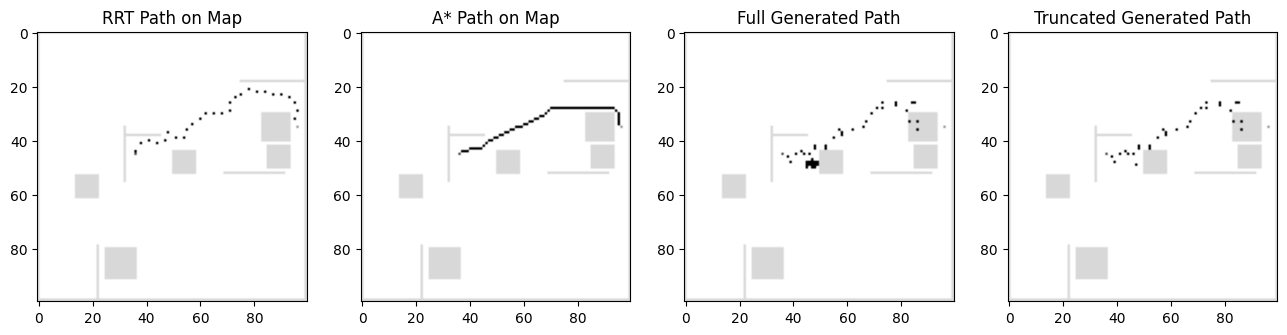

Epoch [72/1000], Total Steps: 2304, G Total Loss: 266.1333923339844, D Loss: 1.4130700826644897
Epoch [73/1000], Total Steps: 2336, G Total Loss: 273.1869812011719, D Loss: 1.4075393676757812
Epoch [74/1000], Total Steps: 2368, G Total Loss: 350.85302734375, D Loss: 1.360371708869934
Epoch [75/1000], Total Steps: 2400, G Total Loss: 310.4430847167969, D Loss: 1.3990490436553955
Epoch [76/1000], Total Steps: 2432, G Total Loss: 250.63851928710938, D Loss: 1.3960801362991333
Epoch [77/1000], Total Steps: 2464, G Total Loss: 258.88421630859375, D Loss: 1.386366605758667
Epoch [78/1000], Total Steps: 2496, G Total Loss: 315.7247009277344, D Loss: 1.388382911682129
Epoch [79/1000], Total Steps: 2528, G Total Loss: 288.2449951171875, D Loss: 1.3670111894607544
Epoch [80/1000], Total Steps: 2560, G Total Loss: 277.84747314453125, D Loss: 1.3838152885437012
Epoch [81/1000], Total Steps: 2592, G Total Loss: 232.51234436035156, D Loss: 1.3872275352478027
Checkpoint saved at epoch 80.


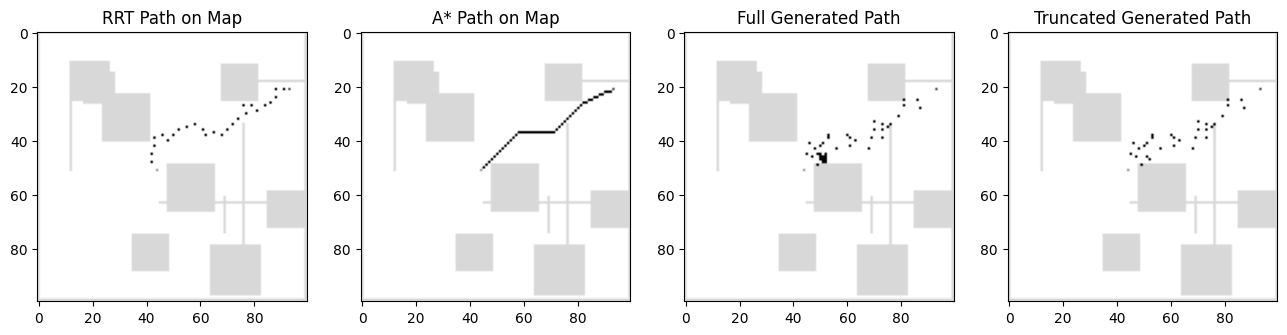

Epoch [82/1000], Total Steps: 2624, G Total Loss: 290.68402099609375, D Loss: 1.355910301208496
Epoch [83/1000], Total Steps: 2656, G Total Loss: 295.94049072265625, D Loss: 1.4047155380249023
Epoch [84/1000], Total Steps: 2688, G Total Loss: 305.514892578125, D Loss: 1.421958327293396
Epoch [85/1000], Total Steps: 2720, G Total Loss: 392.3979187011719, D Loss: 1.3723156452178955
Epoch [86/1000], Total Steps: 2752, G Total Loss: 229.9906463623047, D Loss: 1.397770643234253
Epoch [87/1000], Total Steps: 2784, G Total Loss: 235.0971221923828, D Loss: 1.3983075618743896
Epoch [88/1000], Total Steps: 2816, G Total Loss: 261.5401306152344, D Loss: 1.4124377965927124
Epoch [89/1000], Total Steps: 2848, G Total Loss: 341.9989318847656, D Loss: 1.4277724027633667
Epoch [90/1000], Total Steps: 2880, G Total Loss: 199.07525634765625, D Loss: 1.3532640933990479
Epoch [91/1000], Total Steps: 2912, G Total Loss: 262.29693603515625, D Loss: 1.4328632354736328
Checkpoint saved at epoch 90.


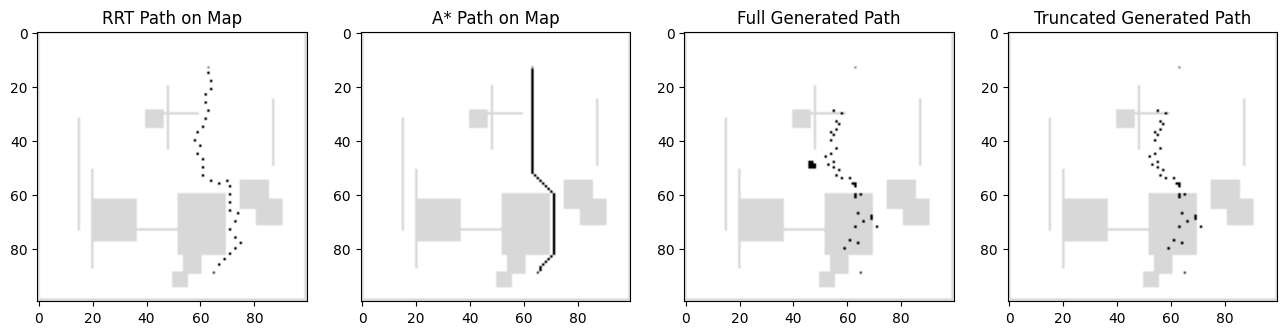

Epoch [92/1000], Total Steps: 2944, G Total Loss: 325.0555419921875, D Loss: 1.3957622051239014
Epoch [93/1000], Total Steps: 2976, G Total Loss: 344.96038818359375, D Loss: 1.3769593238830566
Epoch [94/1000], Total Steps: 3008, G Total Loss: 300.9503173828125, D Loss: 1.3930513858795166
Epoch [95/1000], Total Steps: 3040, G Total Loss: 424.18408203125, D Loss: 1.355015516281128
Epoch [96/1000], Total Steps: 3072, G Total Loss: 277.37774658203125, D Loss: 1.3771497011184692
Epoch [97/1000], Total Steps: 3104, G Total Loss: 260.1783142089844, D Loss: 1.3787565231323242
Epoch [98/1000], Total Steps: 3136, G Total Loss: 244.22821044921875, D Loss: 1.4008562564849854
Best Model Saved at Gen_Loss: 152.12008666992188.
Epoch [99/1000], Total Steps: 3168, G Total Loss: 152.12008666992188, D Loss: 1.3842437267303467
Epoch [100/1000], Total Steps: 3200, G Total Loss: 328.05718994140625, D Loss: 1.3712294101715088
Epoch [101/1000], Total Steps: 3232, G Total Loss: 229.44264221191406, D Loss: 1.39

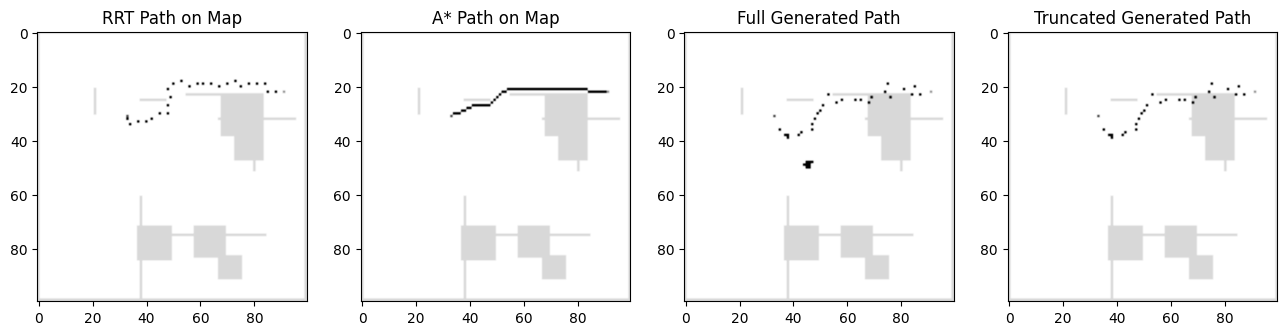

Epoch [102/1000], Total Steps: 3264, G Total Loss: 291.19671630859375, D Loss: 1.4060232639312744
Epoch [103/1000], Total Steps: 3296, G Total Loss: 291.1594543457031, D Loss: 1.390931248664856
Epoch [104/1000], Total Steps: 3328, G Total Loss: 211.14463806152344, D Loss: 1.38102126121521
Best Model Saved at Gen_Loss: 137.50042724609375.
Epoch [105/1000], Total Steps: 3360, G Total Loss: 137.50042724609375, D Loss: 1.3791248798370361
Epoch [106/1000], Total Steps: 3392, G Total Loss: 248.23760986328125, D Loss: 1.4096815586090088
Epoch [107/1000], Total Steps: 3424, G Total Loss: 403.9651794433594, D Loss: 1.4143848419189453
Epoch [108/1000], Total Steps: 3456, G Total Loss: 338.024169921875, D Loss: 1.4048998355865479
Epoch [109/1000], Total Steps: 3488, G Total Loss: 251.3439483642578, D Loss: 1.3490854501724243
Epoch [110/1000], Total Steps: 3520, G Total Loss: 319.61199951171875, D Loss: 1.3835293054580688
Epoch [111/1000], Total Steps: 3552, G Total Loss: 365.9820556640625, D Loss

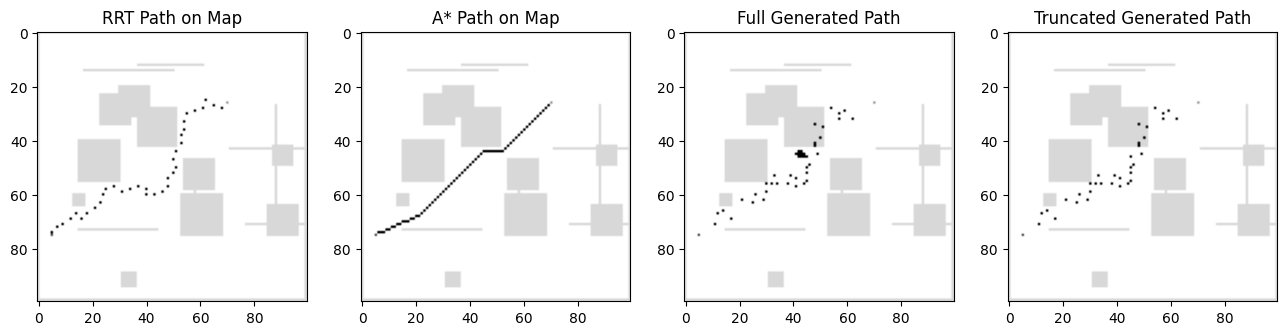

Epoch [112/1000], Total Steps: 3584, G Total Loss: 304.0798034667969, D Loss: 1.3843166828155518
Epoch [113/1000], Total Steps: 3616, G Total Loss: 317.50201416015625, D Loss: 1.396880030632019
Epoch [114/1000], Total Steps: 3648, G Total Loss: 333.2825622558594, D Loss: 1.3705945014953613
Epoch [115/1000], Total Steps: 3680, G Total Loss: 268.3073425292969, D Loss: 1.3446578979492188
Epoch [116/1000], Total Steps: 3712, G Total Loss: 298.9298095703125, D Loss: 1.4554530382156372
Epoch [117/1000], Total Steps: 3744, G Total Loss: 304.7735900878906, D Loss: 1.4103411436080933
Epoch [118/1000], Total Steps: 3776, G Total Loss: 211.98312377929688, D Loss: 1.43460214138031
Epoch [119/1000], Total Steps: 3808, G Total Loss: 443.2906799316406, D Loss: 1.3661421537399292
Epoch [120/1000], Total Steps: 3840, G Total Loss: 231.62950134277344, D Loss: 1.417036771774292
Epoch [121/1000], Total Steps: 3872, G Total Loss: 329.3909606933594, D Loss: 1.3965563774108887
Checkpoint saved at epoch 120.


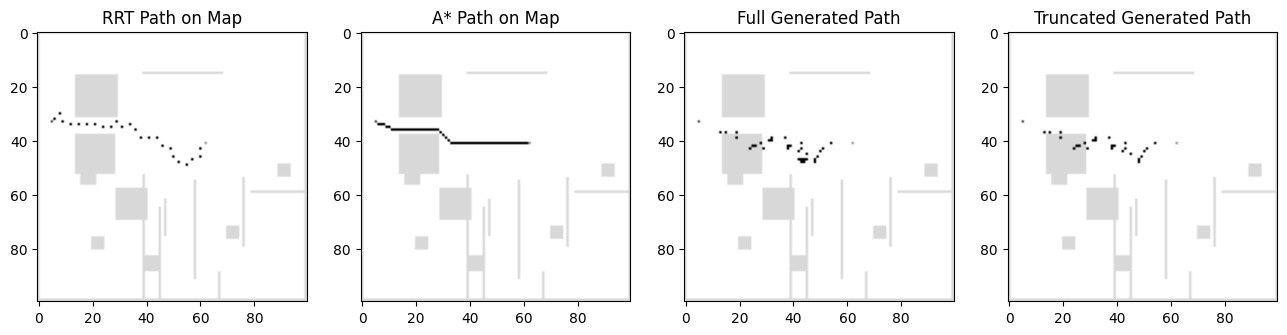

Epoch [122/1000], Total Steps: 3904, G Total Loss: 215.74990844726562, D Loss: 1.3827991485595703
Epoch [123/1000], Total Steps: 3936, G Total Loss: 249.3480987548828, D Loss: 1.33412504196167
Epoch [124/1000], Total Steps: 3968, G Total Loss: 289.1534423828125, D Loss: 1.3924206495285034
Epoch [125/1000], Total Steps: 4000, G Total Loss: 194.53904724121094, D Loss: 1.3887971639633179
Epoch [126/1000], Total Steps: 4032, G Total Loss: 293.0192565917969, D Loss: 1.3947582244873047
Epoch [127/1000], Total Steps: 4064, G Total Loss: 192.42156982421875, D Loss: 1.3704913854599
Epoch [128/1000], Total Steps: 4096, G Total Loss: 268.9710998535156, D Loss: 1.3919596672058105
Epoch [129/1000], Total Steps: 4128, G Total Loss: 242.41229248046875, D Loss: 1.3999409675598145
Epoch [130/1000], Total Steps: 4160, G Total Loss: 253.38507080078125, D Loss: 1.3784332275390625
Epoch [131/1000], Total Steps: 4192, G Total Loss: 230.80462646484375, D Loss: 1.3809436559677124
Checkpoint saved at epoch 130

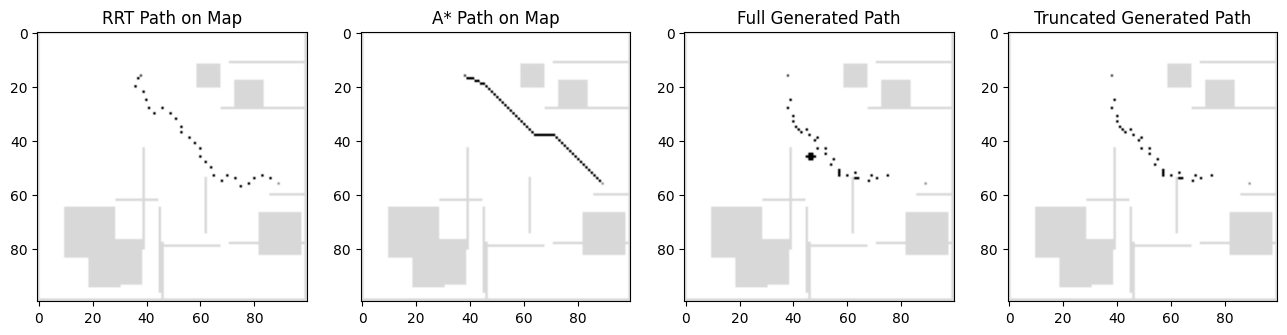

Epoch [132/1000], Total Steps: 4224, G Total Loss: 245.38038635253906, D Loss: 1.4298813343048096
Epoch [133/1000], Total Steps: 4256, G Total Loss: 308.6911315917969, D Loss: 1.3852546215057373
Epoch [134/1000], Total Steps: 4288, G Total Loss: 241.11207580566406, D Loss: 1.393178939819336
Epoch [135/1000], Total Steps: 4320, G Total Loss: 289.48822021484375, D Loss: 1.3778550624847412
Epoch [136/1000], Total Steps: 4352, G Total Loss: 226.1851806640625, D Loss: 1.3783230781555176
Epoch [137/1000], Total Steps: 4384, G Total Loss: 430.5679931640625, D Loss: 1.3684641122817993
Epoch [138/1000], Total Steps: 4416, G Total Loss: 245.56468200683594, D Loss: 1.3732337951660156
Epoch [139/1000], Total Steps: 4448, G Total Loss: 223.361328125, D Loss: 1.3593424558639526
Epoch [140/1000], Total Steps: 4480, G Total Loss: 306.6986389160156, D Loss: 1.3664188385009766
Epoch [141/1000], Total Steps: 4512, G Total Loss: 272.0348205566406, D Loss: 1.3846659660339355
Checkpoint saved at epoch 140.


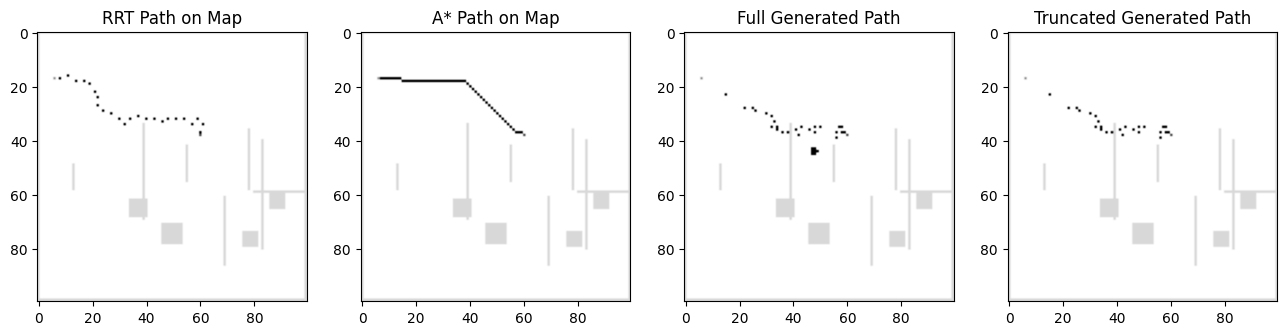

Epoch [142/1000], Total Steps: 4544, G Total Loss: 282.83087158203125, D Loss: 1.3969149589538574
Epoch [143/1000], Total Steps: 4576, G Total Loss: 291.4857177734375, D Loss: 1.350068211555481
Epoch [144/1000], Total Steps: 4608, G Total Loss: 282.3960876464844, D Loss: 1.348376750946045
Epoch [145/1000], Total Steps: 4640, G Total Loss: 320.4023742675781, D Loss: 1.3636901378631592
Epoch [146/1000], Total Steps: 4672, G Total Loss: 336.3636779785156, D Loss: 1.3790066242218018
Epoch [147/1000], Total Steps: 4704, G Total Loss: 374.889404296875, D Loss: 1.3819386959075928
Epoch [148/1000], Total Steps: 4736, G Total Loss: 158.93197631835938, D Loss: 1.3877613544464111
Epoch [149/1000], Total Steps: 4768, G Total Loss: 218.90858459472656, D Loss: 1.3830199241638184
Epoch [150/1000], Total Steps: 4800, G Total Loss: 312.3753967285156, D Loss: 1.418139934539795
Epoch [151/1000], Total Steps: 4832, G Total Loss: 257.59832763671875, D Loss: 1.35081148147583
Checkpoint saved at epoch 150.


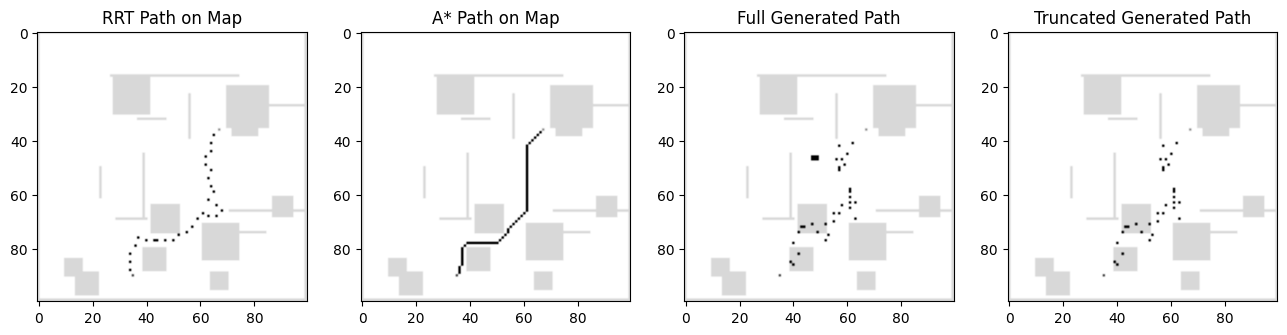

Epoch [152/1000], Total Steps: 4864, G Total Loss: 307.8887023925781, D Loss: 1.376384973526001
Epoch [153/1000], Total Steps: 4896, G Total Loss: 237.58380126953125, D Loss: 1.416762351989746
Epoch [154/1000], Total Steps: 4928, G Total Loss: 238.11375427246094, D Loss: 1.3771350383758545
Epoch [155/1000], Total Steps: 4960, G Total Loss: 251.49000549316406, D Loss: 1.3701512813568115
Epoch [156/1000], Total Steps: 4992, G Total Loss: 235.58680725097656, D Loss: 1.3734097480773926
Epoch [157/1000], Total Steps: 5024, G Total Loss: 311.4116516113281, D Loss: 1.4166275262832642
Epoch [158/1000], Total Steps: 5056, G Total Loss: 240.725341796875, D Loss: 1.3556287288665771
Epoch [159/1000], Total Steps: 5088, G Total Loss: 283.1157531738281, D Loss: 1.3874905109405518
Epoch [160/1000], Total Steps: 5120, G Total Loss: 304.6399230957031, D Loss: 1.4102027416229248
Epoch [161/1000], Total Steps: 5152, G Total Loss: 306.3663635253906, D Loss: 1.356670618057251
Checkpoint saved at epoch 160.

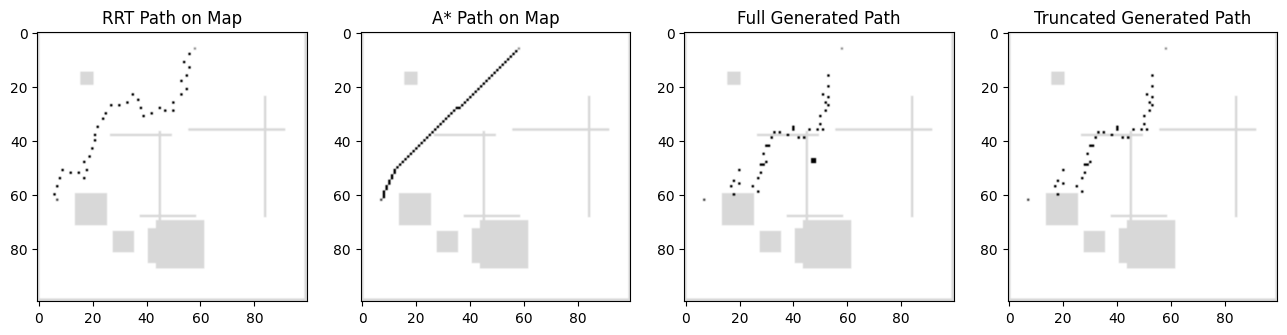

Epoch [162/1000], Total Steps: 5184, G Total Loss: 342.2926330566406, D Loss: 1.3630762100219727
Epoch [163/1000], Total Steps: 5216, G Total Loss: 250.97225952148438, D Loss: 1.3591423034667969
Epoch [164/1000], Total Steps: 5248, G Total Loss: 353.2617492675781, D Loss: 1.3746002912521362
Epoch [165/1000], Total Steps: 5280, G Total Loss: 315.1668701171875, D Loss: 1.3763906955718994
Epoch [166/1000], Total Steps: 5312, G Total Loss: 270.6731262207031, D Loss: 1.4289987087249756
Epoch [167/1000], Total Steps: 5344, G Total Loss: 229.20001220703125, D Loss: 1.3489731550216675
Epoch [168/1000], Total Steps: 5376, G Total Loss: 314.59210205078125, D Loss: 1.3719065189361572
Epoch [169/1000], Total Steps: 5408, G Total Loss: 325.01568603515625, D Loss: 1.4031139612197876
Epoch [170/1000], Total Steps: 5440, G Total Loss: 343.3558044433594, D Loss: 1.4019701480865479
Epoch [171/1000], Total Steps: 5472, G Total Loss: 290.33404541015625, D Loss: 1.3764863014221191
Checkpoint saved at epoch

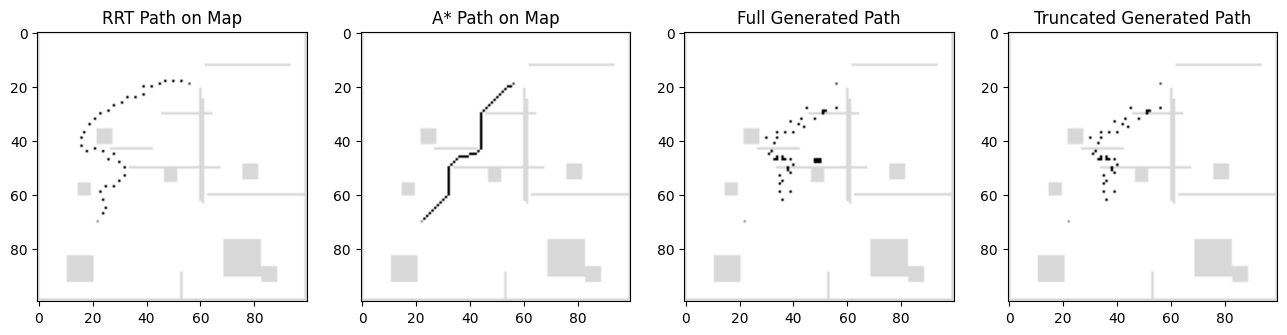

Epoch [172/1000], Total Steps: 5504, G Total Loss: 318.8305969238281, D Loss: 1.3827760219573975
Epoch [173/1000], Total Steps: 5536, G Total Loss: 401.9974365234375, D Loss: 1.4312963485717773
Epoch [174/1000], Total Steps: 5568, G Total Loss: 276.4911804199219, D Loss: 1.383243441581726
Epoch [175/1000], Total Steps: 5600, G Total Loss: 357.3699951171875, D Loss: 1.3899691104888916
Epoch [176/1000], Total Steps: 5632, G Total Loss: 309.03887939453125, D Loss: 1.3937256336212158
Epoch [177/1000], Total Steps: 5664, G Total Loss: 183.7659454345703, D Loss: 1.3497629165649414
Epoch [178/1000], Total Steps: 5696, G Total Loss: 264.6123046875, D Loss: 1.405776023864746
Epoch [179/1000], Total Steps: 5728, G Total Loss: 344.0661926269531, D Loss: 1.370455265045166
Epoch [180/1000], Total Steps: 5760, G Total Loss: 359.74627685546875, D Loss: 1.3564506769180298
Epoch [181/1000], Total Steps: 5792, G Total Loss: 291.7017822265625, D Loss: 1.4017125368118286
Checkpoint saved at epoch 180.


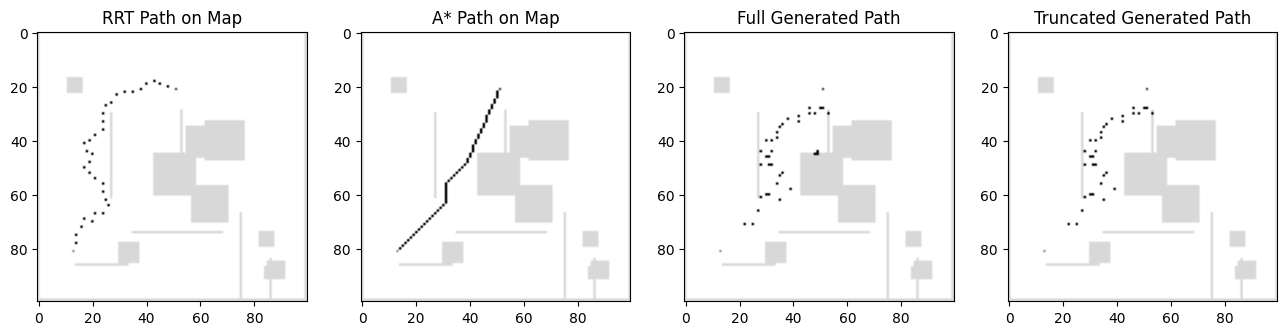

Epoch [182/1000], Total Steps: 5824, G Total Loss: 248.13812255859375, D Loss: 1.385826587677002
Epoch [183/1000], Total Steps: 5856, G Total Loss: 304.6343078613281, D Loss: 1.382968783378601
Epoch [184/1000], Total Steps: 5888, G Total Loss: 346.62408447265625, D Loss: 1.3748008012771606
Epoch [185/1000], Total Steps: 5920, G Total Loss: 210.86373901367188, D Loss: 1.394289255142212
Epoch [186/1000], Total Steps: 5952, G Total Loss: 313.42724609375, D Loss: 1.3482139110565186
Epoch [187/1000], Total Steps: 5984, G Total Loss: 337.38458251953125, D Loss: 1.367629051208496
Epoch [188/1000], Total Steps: 6016, G Total Loss: 314.1524353027344, D Loss: 1.3734850883483887
Epoch [189/1000], Total Steps: 6048, G Total Loss: 377.69952392578125, D Loss: 1.3393070697784424
Epoch [190/1000], Total Steps: 6080, G Total Loss: 239.46258544921875, D Loss: 1.397809386253357
Epoch [191/1000], Total Steps: 6112, G Total Loss: 372.7817077636719, D Loss: 1.37947416305542
Checkpoint saved at epoch 190.


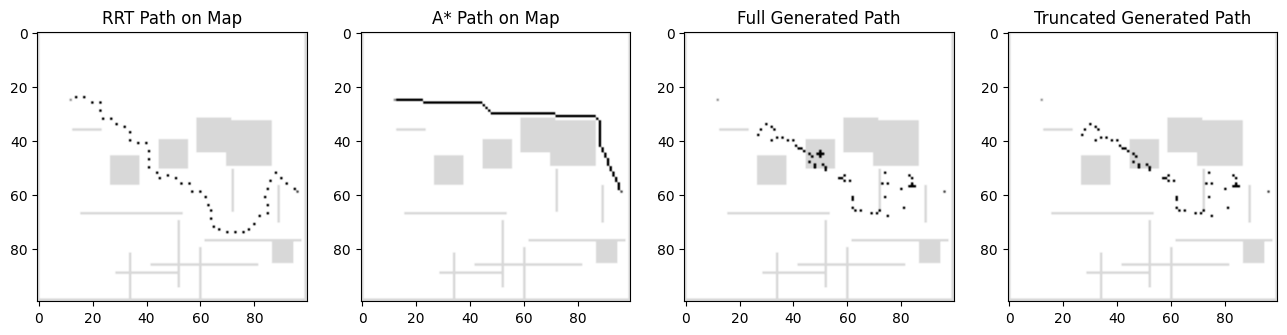

Epoch [192/1000], Total Steps: 6144, G Total Loss: 204.5731964111328, D Loss: 1.4219930171966553
Epoch [193/1000], Total Steps: 6176, G Total Loss: 267.16302490234375, D Loss: 1.3492364883422852
Epoch [194/1000], Total Steps: 6208, G Total Loss: 197.31809997558594, D Loss: 1.349388837814331
Epoch [195/1000], Total Steps: 6240, G Total Loss: 343.1863708496094, D Loss: 1.4146530628204346
Epoch [196/1000], Total Steps: 6272, G Total Loss: 276.50799560546875, D Loss: 1.4024910926818848
Epoch [197/1000], Total Steps: 6304, G Total Loss: 251.2887420654297, D Loss: 1.400285243988037
Epoch [198/1000], Total Steps: 6336, G Total Loss: 229.0742645263672, D Loss: 1.398821473121643
Epoch [199/1000], Total Steps: 6368, G Total Loss: 313.32183837890625, D Loss: 1.3992836475372314
Epoch [200/1000], Total Steps: 6400, G Total Loss: 210.3765106201172, D Loss: 1.3806116580963135
Epoch [201/1000], Total Steps: 6432, G Total Loss: 439.9389953613281, D Loss: 1.4000790119171143
Checkpoint saved at epoch 200

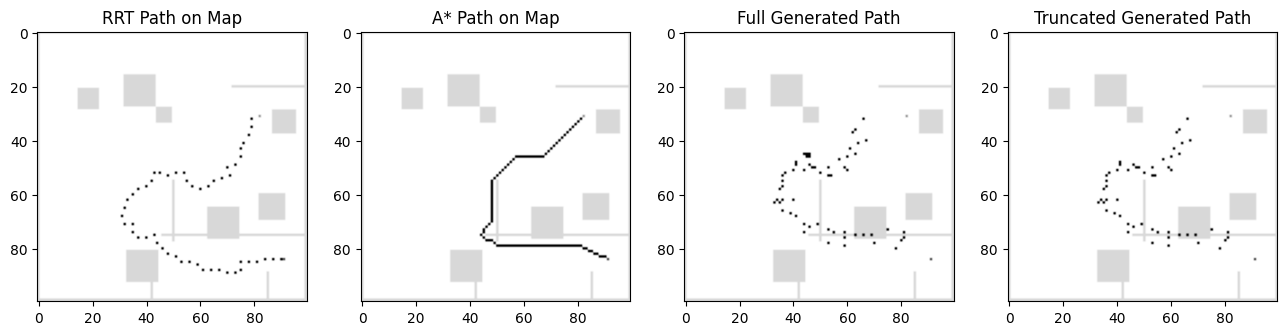

Epoch [202/1000], Total Steps: 6464, G Total Loss: 250.93775939941406, D Loss: 1.4387712478637695
Epoch [203/1000], Total Steps: 6496, G Total Loss: 318.9370422363281, D Loss: 1.3822436332702637
Epoch [204/1000], Total Steps: 6528, G Total Loss: 301.26715087890625, D Loss: 1.363143801689148
Epoch [205/1000], Total Steps: 6560, G Total Loss: 284.34783935546875, D Loss: 1.3770720958709717
Epoch [206/1000], Total Steps: 6592, G Total Loss: 314.0312805175781, D Loss: 1.4130054712295532
Epoch [207/1000], Total Steps: 6624, G Total Loss: 155.07427978515625, D Loss: 1.403961420059204
Epoch [208/1000], Total Steps: 6656, G Total Loss: 316.9075622558594, D Loss: 1.3563740253448486
Epoch [209/1000], Total Steps: 6688, G Total Loss: 418.3975830078125, D Loss: 1.3699389696121216
Epoch [210/1000], Total Steps: 6720, G Total Loss: 262.5997009277344, D Loss: 1.3818413019180298
Epoch [211/1000], Total Steps: 6752, G Total Loss: 321.36724853515625, D Loss: 1.3883569240570068
Checkpoint saved at epoch 2

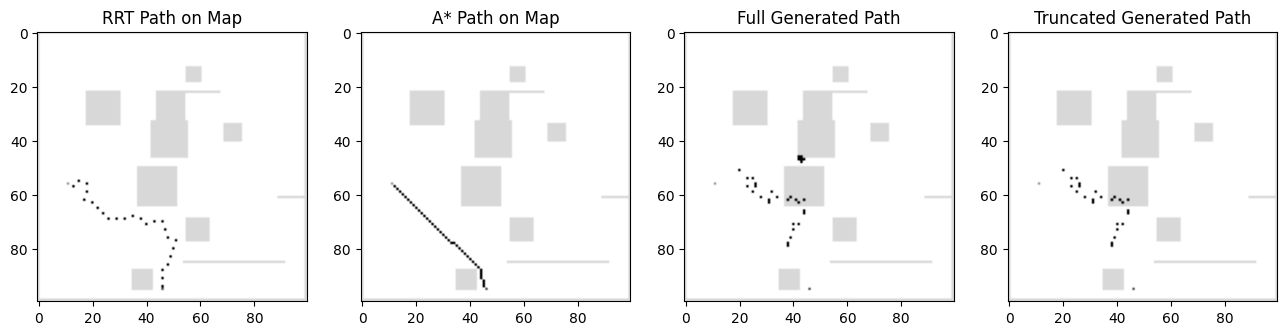

Epoch [212/1000], Total Steps: 6784, G Total Loss: 345.1075744628906, D Loss: 1.3819186687469482
Epoch [213/1000], Total Steps: 6816, G Total Loss: 283.0997314453125, D Loss: 1.387332558631897
Epoch [214/1000], Total Steps: 6848, G Total Loss: 316.39349365234375, D Loss: 1.379253625869751
Epoch [215/1000], Total Steps: 6880, G Total Loss: 236.23387145996094, D Loss: 1.3834378719329834
Epoch [216/1000], Total Steps: 6912, G Total Loss: 217.97572326660156, D Loss: 1.3949373960494995
Epoch [217/1000], Total Steps: 6944, G Total Loss: 311.69476318359375, D Loss: 1.3876872062683105
Epoch [218/1000], Total Steps: 6976, G Total Loss: 228.8458251953125, D Loss: 1.4132473468780518
Epoch [219/1000], Total Steps: 7008, G Total Loss: 282.01019287109375, D Loss: 1.4153344631195068
Epoch [220/1000], Total Steps: 7040, G Total Loss: 236.50914001464844, D Loss: 1.3759770393371582
Epoch [221/1000], Total Steps: 7072, G Total Loss: 248.3488311767578, D Loss: 1.3890126943588257
Checkpoint saved at epoch 

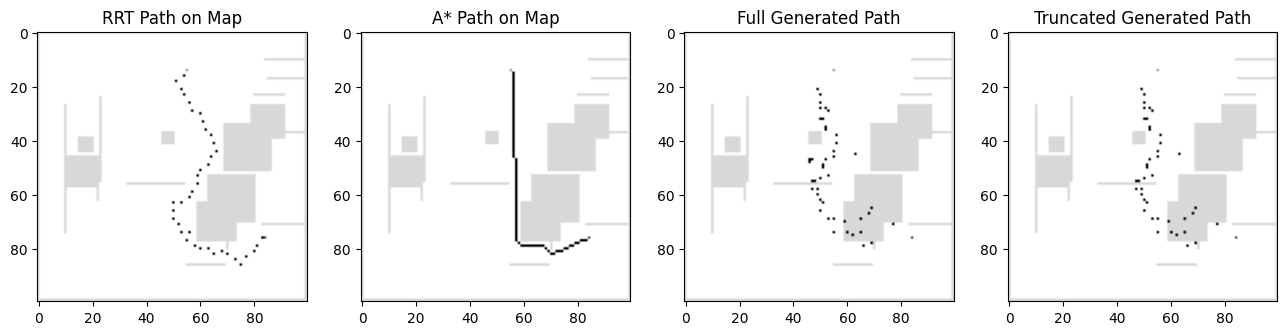

Epoch [222/1000], Total Steps: 7104, G Total Loss: 271.44696044921875, D Loss: 1.3947997093200684
Epoch [223/1000], Total Steps: 7136, G Total Loss: 261.24139404296875, D Loss: 1.3586102724075317
Epoch [224/1000], Total Steps: 7168, G Total Loss: 259.142822265625, D Loss: 1.417879581451416
Epoch [225/1000], Total Steps: 7200, G Total Loss: 309.2059020996094, D Loss: 1.3674201965332031
Epoch [226/1000], Total Steps: 7232, G Total Loss: 309.74542236328125, D Loss: 1.388961672782898
Epoch [227/1000], Total Steps: 7264, G Total Loss: 229.19345092773438, D Loss: 1.4218852519989014
Epoch [228/1000], Total Steps: 7296, G Total Loss: 285.6367492675781, D Loss: 1.3847662210464478
Epoch [229/1000], Total Steps: 7328, G Total Loss: 258.9017639160156, D Loss: 1.3943068981170654
Epoch [230/1000], Total Steps: 7360, G Total Loss: 344.7412414550781, D Loss: 1.4108306169509888
Epoch [231/1000], Total Steps: 7392, G Total Loss: 180.5349578857422, D Loss: 1.4116647243499756
Checkpoint saved at epoch 230

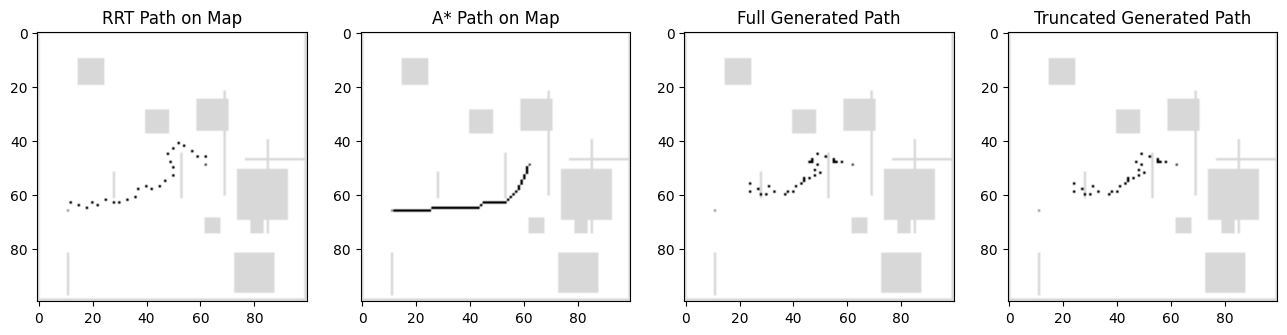

Epoch [232/1000], Total Steps: 7424, G Total Loss: 324.31512451171875, D Loss: 1.3848563432693481
Epoch [233/1000], Total Steps: 7456, G Total Loss: 234.8472442626953, D Loss: 1.3182594776153564
Epoch [234/1000], Total Steps: 7488, G Total Loss: 297.140869140625, D Loss: 1.4013020992279053
Epoch [235/1000], Total Steps: 7520, G Total Loss: 232.689697265625, D Loss: 1.3938257694244385
Epoch [236/1000], Total Steps: 7552, G Total Loss: 354.6192321777344, D Loss: 1.4235587120056152
Epoch [237/1000], Total Steps: 7584, G Total Loss: 282.7869873046875, D Loss: 1.3736770153045654
Epoch [238/1000], Total Steps: 7616, G Total Loss: 249.5038604736328, D Loss: 1.3476982116699219
Epoch [239/1000], Total Steps: 7648, G Total Loss: 246.89573669433594, D Loss: 1.35422945022583
Epoch [240/1000], Total Steps: 7680, G Total Loss: 307.3800964355469, D Loss: 1.400930643081665
Epoch [241/1000], Total Steps: 7712, G Total Loss: 176.00271606445312, D Loss: 1.3894588947296143
Checkpoint saved at epoch 240.


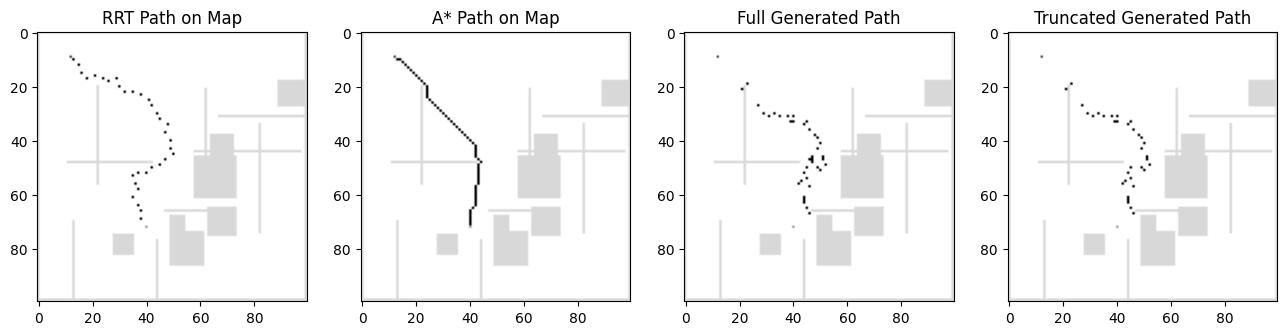

Epoch [242/1000], Total Steps: 7744, G Total Loss: 282.6658935546875, D Loss: 1.3418643474578857
Epoch [243/1000], Total Steps: 7776, G Total Loss: 294.82757568359375, D Loss: 1.3824968338012695
Epoch [244/1000], Total Steps: 7808, G Total Loss: 263.1479797363281, D Loss: 1.4166836738586426
Epoch [245/1000], Total Steps: 7840, G Total Loss: 263.38525390625, D Loss: 1.3809605836868286
Epoch [246/1000], Total Steps: 7872, G Total Loss: 345.9085998535156, D Loss: 1.3878495693206787


KeyboardInterrupt: ignored

In [ ]:
# Parameters
num_epochs = 1000 # Number of epochs for training

# Initialize your models
generator = Generator(input_channels, output_channels, embedding_dim, nhead, num_encoder_layers, num_decoder_layers).to(device)
discriminator = Discriminator(image_size=100).to(device)

# Define optimizers for both generator and discriminator
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Keep track of minimum loss for model saving
best_g_total_loss = float('inf')

# TensorBoard setup
log_dir = 'runs/GAN_experiment'
os.makedirs(log_dir, exist_ok=True)
# Setup TensorBoard writer
writer = SummaryWriter(log_dir)

# Checkpointing functions
def save_checkpoint(model, optimizer, filename):
    """
    Save a model checkpoint.

    Parameters:
    - model: PyTorch model to be saved
    - optimizer: Optimizer state to be saved
    - filename: Path where the checkpoint will be saved
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

total_steps = 0

for epoch in range(num_epochs):
    for step, data in enumerate(dataloader):
        # Load data and transfer to device
        map_tensor = data['map'].to(device).unsqueeze(1)
        rrt_path_tensor = data['rrt_path'].to(device)
        astar_path_tensor = data['astar_path'].to(device)
        rrt_mask_tensor = data['rrt_mask'].to(device)
        astar_mask_tensor = data['astar_mask'].to(device)


        # Generate paths from the generator
        generated_path, eos_probabilities = generator(map_tensor, rrt_path_tensor, rrt_mask_tensor)

        # Modify maps with paths
        rrt_modified_maps = modify_maps_with_paths_tensor(map_tensor, rrt_path_tensor, rrt_mask_tensor)
        astar_modified_maps = modify_maps_with_paths_tensor(map_tensor, astar_path_tensor, astar_mask_tensor)

        # Truncate the generated path and modify maps with it
        truncated_generated_paths_tensor = find_truncated_paths_batch(generated_path.detach(), eos_probabilities.detach(), eos_threshold=0.9)
        generated_modified_maps = modify_maps_with_paths_tensor(map_tensor, truncated_generated_paths_tensor, None)

        # Train Discriminator
        # if step % 10 == 0:  # Update discriminator conditionally
        disc_optimizer.zero_grad()
        # Get discriminator outputs for real and fake data
        disc_real_output = discriminator(rrt_modified_maps, astar_modified_maps)
        disc_fake_output = discriminator(rrt_modified_maps, generated_modified_maps.detach())
        # Calculate total discriminator loss
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
        # Backward pass and optimizer step
        disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()
        disc_fake_output = discriminator(rrt_modified_maps, generated_modified_maps)
        gen_loss = generator_loss(disc_fake_output, generated_path, astar_path_tensor, eos_probabilities, astar_mask_tensor, generated_modified_maps, map_tensor)
        gen_loss.backward()
        gen_optimizer.step()

        total_steps += 1  # Increment total steps

        # Logging
        if step % 100 == 0:
            # Instead of printing every 100 steps, you'll log to TensorBoard
            writer.add_scalar('Generator Total Loss', gen_loss.item(), global_step=total_steps)
            writer.add_scalar('Discriminator Loss', disc_loss.item(), global_step=total_steps)

        # Save model checkpoints if new minimum generator loss is achieved
        if gen_loss.item() < best_g_total_loss:
            best_g_total_loss = gen_loss.item()
            # Define 'save_checkpoint' to save your model's checkpoint
            save_checkpoint(generator, gen_optimizer, 'best_generator_checkpoint.pth')
            save_checkpoint(discriminator, disc_optimizer, 'best_discriminator_checkpoint.pth')
            print(f"Best Model Saved at Gen_Loss: {best_g_total_loss}.")

    # Print and log at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Steps: {total_steps}, G Total Loss: {gen_loss.item()}, D Loss: {disc_loss.item()}")

    # Save checkpoint every 10 epochs
    if (epoch) % 10 == 0:
        checkpoint_name_generator = f'checkpoint_generator.pth'
        checkpoint_name_discriminator = f'checkpoint_discriminator.pth'
        save_checkpoint(generator, gen_optimizer, checkpoint_name_generator)
        save_checkpoint(discriminator, disc_optimizer, checkpoint_name_discriminator)
        print(f"Checkpoint saved at epoch {epoch}.")


        # Visualization
        with torch.no_grad():
            # Get a batch of data
            sample_data = next(iter(dataloader))
            sample_map = sample_data['map'][0].numpy()
            sample_rrt_path = sample_data['rrt_path'][0].numpy()
            sample_astar_path = sample_data['astar_path'][0].numpy()
            sample_rrt_mask = sample_data['rrt_mask'][0].numpy()
            sample_astar_mask = sample_data['astar_mask'][0].numpy()

            # Modify maps with paths
            rrt_modified_map = modify_map_with_path(sample_map, sample_rrt_path, sample_rrt_mask)
            astar_modified_map = modify_map_with_path(sample_map, sample_astar_path, sample_astar_mask)

            # Generate output map
            generated_path, eos_probabilities = generator(torch.from_numpy(sample_map).unsqueeze(0).to(device),
                                                          torch.from_numpy(sample_rrt_path).unsqueeze(0).to(device),
                                                          torch.from_numpy(sample_rrt_mask).unsqueeze(0).to(device))

            # Convert back to NumPy arrays
            generated_path_np = generated_path.squeeze().cpu().numpy()
            eos_probabilities_np = eos_probabilities.squeeze().cpu().numpy()

            # Truncate the path
            eos_threshold = 0.9
            truncated_path_np = find_truncated_path(generated_path_np, eos_probabilities_np, eos_threshold)

            # Plot the maps
            plot_maps(rrt_modified_map, astar_modified_map, generated_path_np, truncated_path_np, sample_map)
